In [66]:
import os

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from einops import repeat
from einops.layers.torch import Rearrange

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Dataset

In [3]:
dset_root = '/data4/datasets/'  # Choose a place on your machine to store data.

train_dataset = datasets.CIFAR10(root=dset_root, train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.CIFAR10(root=dset_root, train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


## Visualize dataset

In [106]:
example_index = 500
image, label = train_dataset.__getitem__(example_index)

print(image.shape)

torch.Size([3, 32, 32])


Text(0.5, 1.0, 'Class: dog')

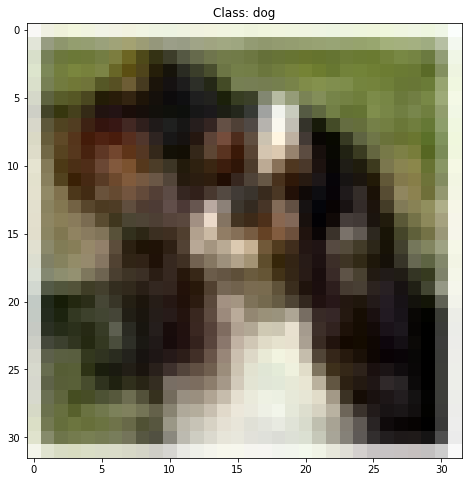

In [105]:
image = np.asarray(image)
_, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(image.transpose(1,2,0))
ax.set_title(f'Class: {train_dataset.classes[label]}')

# Model

## Building the ViT model

In [85]:
# Code inspired by: https://github.com/lucidrains/vit-pytorch/blob/89e1996c8bde31c6aeda33dbdde2aee72697a493/vit_pytorch/vit.py#L94

class ViT(nn.Module):
    def __init__(self, n_classes, image_size, patch_size, feature_dim, n_heads, n_layers, n_channels=3):
        super().__init__()

        # Initialize private variables.
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.image_size = image_size
        self.patch_size = patch_size
        self.feature_dim = feature_dim

        # Make sure that image size is viable.
        n_patches = self._check_image_dimensions()

        # Build network.
        self.encoder, self.cls_layer = self._build_model()

        # Build image to patches to token function.
        patch_height, patch_width = patch_size
        patch_dim = n_channels * patch_height * patch_width
        self.tokenizer = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, feature_dim),
        )

        # Create special classification token.
        self.cls_token = nn.Parameter(torch.randn(1, 1, feature_dim))

        # Generate postitional embedding.
        ## Use learnable positional embedding, simpler but less efficient than sinusoidal pos embeddings.
        self.pos_embedding = nn.Parameter(torch.randn(1, n_patches + 1, feature_dim))

    def _check_image_dimensions(self):
        image_height, image_width = self.image_size
        patch_height, patch_width = self.patch_size
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        n_patches = (image_height // patch_height) * (image_width // patch_width)

        return n_patches

    def _build_model(self):
        # Create Transformer network.

        ## Build base encoding layer.
        enc_layer = nn.TransformerEncoderLayer(d_model=self.feature_dim, nhead=self.n_heads, dim_feedforward=self.feature_dim, batch_first=True)
        
        ## Wrap/repeat encoding layers into Transformer Encoder.
        encoder = nn.TransformerEncoder(enc_layer, num_layers=self.n_layers, norm=nn.LayerNorm(self.feature_dim))
        # encoder = nn.TransformerEncoder(enc_layer, num_layers=self.n_layers)

        # Create classification network.
        cls_layer = nn.Linear(self.feature_dim, self.n_classes)

        return encoder, cls_layer

    def forward(self, image):
        # Convert image to tokens
        tokens = self.tokenizer(image)
        b, n, f = tokens.shape  # b = batch_size, n = number of tokens, f = dimension of token

        # Add special token to sequence.
        ## Note: Need to copy special token based on the number of examples in the batch.
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)

        ## Concatenate special token to beginning of input sequence 
        ## Adding it to the beginning or end doesn't matter, you just have to be consistent.
        tokens = torch.cat([cls_tokens, tokens], dim=1)  # shape [b, n+1, f]

        # Add positional embedding to tokens
        tokens = tokens + self.pos_embedding

        # Pass tokens into model.
        output = self.encoder(tokens)

        # Get the output from the special token position.
        cls_output = output[:, 0]

        # Pass cls token output through classification network.
        prediction = self.cls_layer(cls_output)

        return prediction


In [72]:
# Note: This code is for debugging purposes but might be helpful for students.
# It can be ignored
class Test_Model(nn.Module):
    def __init__(self, n_classes, image_size, patch_size, feature_dim, n_heads, n_layers, n_channels=3):
        super().__init__()

        # Initialize private variables.
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.image_size = image_size
        self.patch_size = patch_size
        self.feature_dim = feature_dim

        self.network = self._build_model()

    def _build_model(self):
        network = torchvision.models.resnet18()
        network.fc = nn.Linear(512, self.n_classes)

        return network

    def forward(self, image):
        output = self.network(image)
        return output

In [7]:
# Test network
model = ViT(n_classes=10, image_size=[32, 32], patch_size=[8,8], feature_dim=256, n_heads=4, n_layers=2)

## Create test input.
batch_size = 2
n_channels = 3
height = 32
width = 32
example_input = torch.zeros([batch_size, n_channels, height, width])

## Test model can handle example input.
output = model(example_input)
print(output.shape)

torch.Size([2, 10])


# Train Model

## Create training pipeline.

In [92]:
# Training hyperparameters.
batch_size = 64  # Number of images combined and passed into model for each iteration.
n_workers = 10  # Number of CPUs running this job. (may have to lower this for your machine)
learn_rate = 3e-3
feature_dim = 64
n_heads = 4
n_layers = 2
n_epochs = 10
gamma = 0.8

# Wrap datasets in data loader's (makes data loading parallelizable).
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=False, pin_memory=True)

# Build model.
n_classes = len(train_dataset.classes)
patch_size = [8, 8]
model = ViT(n_classes, [32, 32], patch_size, feature_dim, n_heads, n_layers)
# model = Test_Model(n_classes, [32, 32], patch_size, feature_dim, n_heads, n_layers)

## Get model training device type.
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

## Load model weights into GPU (if available).
model = model.to(device)

# Get optimization function
optimizer = optim.Adam(model.parameters(), learn_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

### Create Training Loop

In [80]:
def train_loop(model, device, train_loader, optimizer):
    model.train()
    train_loss, train_acc, count = [], 0, 0
    for image, target in tqdm(train_loader, desc='Train loop'):
        # Load image and labels into GPU memory (if available).
        image = image.to(device)
        target = target.to(device)

        # Pass data into model.
        optimizer.zero_grad()
        output = model(image)

        # Compute loss.
        loss = nn.functional.cross_entropy(output, target)

        # Compute accuracy.
        pred = output.argmax(dim=1, keepdim=True)
        train_acc += (target.view_as(pred) == pred).sum().item()
        count += image.shape[0]

        # Update network weights.
        loss.backward()
        optimizer.step()

        # Record train loss.
        train_loss.append(loss.item() / image.shape[0])  # Adjust loss by batch size
    
    # Compute overall train acc.
    train_acc /= count

    return train_loss, train_acc


### Create Test Loop

In [81]:
def test_loop(model, device, test_loader):
    model.eval()

    test_loss, test_acc, count = [], 0, 0
    with torch.no_grad():
        for image, target in tqdm(test_loader, desc='Test loop'):
            # Load image and labels into GPU memory (if available).
            image = image.to(device)
            target = target.to(device)

            # Pass data into model.
            output = model(image)

            # Compute loss.
            loss = nn.functional.cross_entropy(output, target)
        
            # Record train loss.
            test_loss.append(loss.item() / image.shape[0])  # Adjust loss by batch size

            # Compute accuracy.
            pred = output.argmax(dim=1, keepdim=True)
            test_acc += (target.view_as(pred) == pred).sum().item()
            count += image.shape[0]
    
    # Compute overall test acc.
    test_acc /= count

    return test_loss, test_acc

## Main Training Loop

In [93]:
iter_train_loss, epoch_train_acc = [], []
iter_test_loss, epoch_test_acc = [], []
for epoch in range(n_epochs):
    print(f'Epoch: [{epoch+1}/{n_epochs}]')
    train_loss, train_acc = train_loop(model, device, train_loader, optimizer)
    test_loss, test_acc = test_loop(model, device, test_loader)
    
    # Update LR of the optimizer with LR scheduler.
    scheduler.step()

    print(f'Avg loss | Train: {np.mean(train_loss)} | Test: {np.mean(test_loss)} |')
    print(f'Avg ACC  | Train: {train_acc*100}% | Test: {test_acc*100}% |')

    iter_train_loss.extend(train_loss)
    iter_test_loss.extend(test_loss)
    epoch_train_acc.append(train_acc)
    epoch_test_acc.append(test_acc)


Epoch: [1/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 128.11it/s]


Avg loss | Train: 0.02936164172523467 | Test: 0.026847159051021953 |
Avg ACC  | Train: 31.5% | Test: 39.489999999999995% |
Epoch: [2/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 130.73it/s]


Avg loss | Train: 0.026184259289804168 | Test: 0.025731337855860684 |
Avg ACC  | Train: 39.488% | Test: 42.17% |
Epoch: [3/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 125.31it/s]


Avg loss | Train: 0.024725555139772423 | Test: 0.02432279202161701 |
Avg ACC  | Train: 43.082% | Test: 45.440000000000005% |
Epoch: [4/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 128.09it/s]


Avg loss | Train: 0.0238385307209571 | Test: 0.02303040964872974 |
Avg ACC  | Train: 45.218% | Test: 47.699999999999996% |
Epoch: [5/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 130.03it/s]


Avg loss | Train: 0.023073158336474615 | Test: 0.022615000759814954 |
Avg ACC  | Train: 47.022000000000006% | Test: 49.16% |
Epoch: [6/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 128.73it/s]


Avg loss | Train: 0.022359775312606942 | Test: 0.022349105708917995 |
Avg ACC  | Train: 48.333999999999996% | Test: 49.61% |
Epoch: [7/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 128.82it/s]


Avg loss | Train: 0.02188915937967465 | Test: 0.021994906210690546 |
Avg ACC  | Train: 49.932% | Test: 50.839999999999996% |
Epoch: [8/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 129.63it/s]


Avg loss | Train: 0.02146658454152286 | Test: 0.02144539623171281 |
Avg ACC  | Train: 50.52799999999999% | Test: 51.43% |
Epoch: [9/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 123.22it/s]


Avg loss | Train: 0.02106130456842501 | Test: 0.021167859909640756 |
Avg ACC  | Train: 51.514% | Test: 52.43% |
Epoch: [10/10]


Test loop: 100%|██████████| 157/157 [00:01<00:00, 130.96it/s]

Avg loss | Train: 0.02076044212669477 | Test: 0.02082688668683456 |
Avg ACC  | Train: 52.459999999999994% | Test: 52.93% |


## Visualize model training

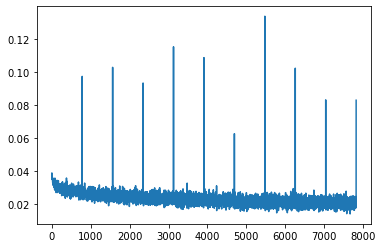

In [94]:
plt.plot(range(len(iter_train_loss)), iter_train_loss)
plt.show()

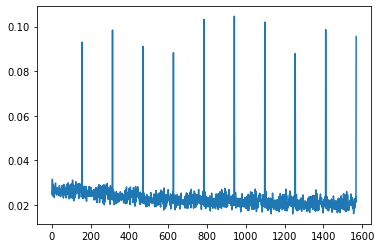

In [95]:
plt.plot(range(len(iter_test_loss)), iter_test_loss)
plt.show()

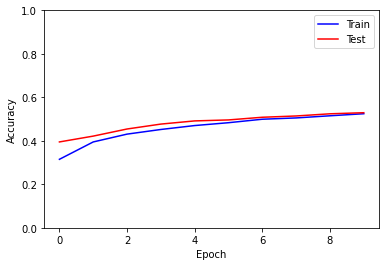

In [107]:
plt.plot(range(n_epochs), epoch_train_acc, '-b')
plt.plot(range(n_epochs), epoch_test_acc, '-r')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
# Homework for 0 credit: Play with the hyperparameters and beat the score here, post it on the Github page!